In [1]:
import sys

%matplotlib inline
import os

import torch
from models.hvae import HVAE

import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

In [2]:
batch_size = 128

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Load a pretrained hvae
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
hvae = HVAE(device)

filename = 'hvae.pth'
import urllib
hvae.load_state_dict(torch.load('./pretrained/'+filename, map_location=device))
hvae = hvae.to(device)
print('model loading done')

cpu
model loading done


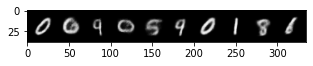

In [5]:
# plot a few samples from the pretrained model
import utils.plot_utils

hvae.eval()

with torch.no_grad():

    # sample images
    img_samples = hvae.sample_x()
    img_samples = img_samples.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    plot_utils.show_image(torchvision.utils.make_grid(img_samples,10,5))
    plt.show()

Original images


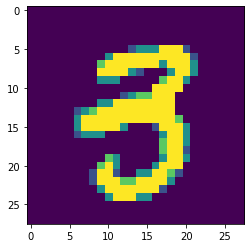

VAE reconstruction:


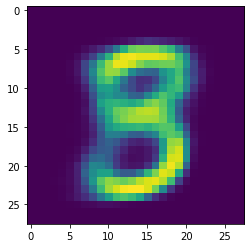

In [6]:
images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
plot_utils.show_image(images[20])
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
plot_utils.show_reconstruct_image(images[20, None], hvae, device)

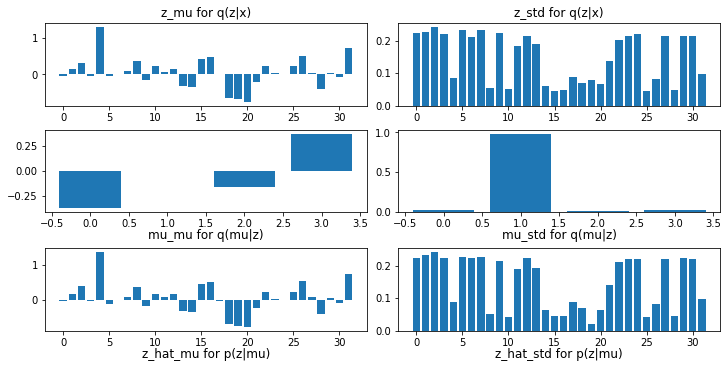

In [8]:
'''
Plot the means and variances of the distribution for all the latent
variables i.e. q(z|x), q(mu|z), p(z|mu). If the variances are too small
or all around the same value for all distribution, there must be something
wrong about that. Similar for means. This can also be used for detecting
model collapsing i.e. posteriors collapse to the prior.
'''
with torch.no_grad():
    z,z_mu, z_logvar = hvae.q_z(images[20, None])
    mu, mu_mu, mu_logvar = hvae.q_mu(z)
    z_hat, pz_mu, pz_logvar = hvae.p_z(mu)

    fig, axs = plt.subplots(3,2, constrained_layout=True)
    fig.set_size_inches(10, 5)
    idx_z = np.arange(len(z_mu.flatten().numpy()))
    idx_mu = np.arange(len(mu_mu.flatten().numpy()))
    axs[0,0].bar(idx_z, z_mu.flatten().numpy())
    axs[0,0].set_title('z_mu for q(z|x)')
    axs[0,1].bar(idx_z, torch.exp(0.5 *z_logvar).flatten().numpy())
    axs[0,1].set_title('z_std for q(z|x)')
    axs[1,0].bar(idx_mu, mu_mu.flatten().numpy())
    axs[1,0].set_title('mu_mu for q(mu|z)', y=-0.4)
    axs[1,1].bar(idx_mu, torch.exp(0.5 *mu_logvar).flatten().numpy())
    axs[1,1].set_title('mu_std for q(mu|z)',y=-0.4)
    axs[2,0].bar(idx_z, pz_mu.flatten().numpy())
    axs[2,0].set_title('z_hat_mu for p(z|mu)', y=-0.4)
    axs[2,1].bar(idx_z, torch.exp(0.5 *pz_logvar).flatten().numpy())
    axs[2,1].set_title('z_hat_std for p(z|mu)', y=-0.4)

    plt.show()

    